### Apply Machine Learning to Match Outcome Retrodiction
### Part 1:  Kaggle European Soccer Database

This study uses Kaggle European Soccer Database and is trying to apply supervised learning to answer 2 questions:
* To what degree can football event data predict match outcome?
* What event types are most related to match outcome?

### Conclusions

* Some model results are summarized below:

|                    Model                            |    Accuracy    | 
| :--------------------------------------------------:| :------------: |
| Random Guess                                        |    34.2%       |
| Always Home Team Win                                |    46.0%       |
| Logistic Regression                                 |    56.6%       |
| Linear Discriminant Analysis                        |    56.6%       |
| Poisson Regression                                  |    56.0%       |
| Gradient Boosting                                   |    56.4%       |
| Random Forest                                       |    55.8%       |
| Neural Network                                      |    56.2%       |

* Cross is ranked 2nd on the feature list, just behind shot. However, cross stats is still often ignored in the media.
* More surprisingly, cross has negative coefficient of team's goal. In other words, more crosses indicate less goals. In this sense, one team's cross stats can be taken as an indicator of opponent's defense quality. So cross stats should be reported and interpreted correctly.

### Table of Contents
#### 1. [Data Preprocessing](#preprocess)
#### 2. [Baseline Results](#baseline)
#### 3. [Model Selection](#model_selection)
#### 4. [Model Evaluation](#model_evaluation)

The original database is downloaded here: [European Soccer Database](https://www.kaggle.com/hugomathien/soccer), and data prepration for this study can be found [here](https://github.com/xzl524/football_data_analysis/tree/master/data_source/kaggle).

#### <a id='preprocess'></a>1. Data Preprocessing

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

sns.set_style('white')
sns.set_context('poster')

#### Load dataset

In [2]:
# Load preprocessed match stats dataset
data_folder = os.path.join(os.path.pardir, os.path.pardir, 'data_source', 'kaggle')
match = pd.read_csv(os.path.join(data_folder, 'match.csv'))

#### Construct features

In [3]:
shot_events = ['shoton', 'shotoff', 'goal']

# Select shot features
home_team_feature = ['home_team_{}'.format(i) for i in shot_events]
away_team_feature = ['away_team_{}'.format(i) for i in shot_events]

# Remove null-data matches
for col in home_team_feature + away_team_feature:
    match = match[match[col].notnull()]

# Construct shot
match['home_team_shot'] = match['home_team_shoton'] + match['home_team_shotoff'] + match['home_team_goal']
match['away_team_shot'] = match['away_team_shoton'] + match['away_team_shotoff'] + match['away_team_goal']

# Extract home team's goal difference for each game
goal_diff = match['home_team_goal'] - match['away_team_goal']

# Encode match result
# home team win:  0
# home team draw: 1
# home team lose: 2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

#### Select event types for modeling

In [4]:
# Select event types
events = ['foulcommit', 'card', 'cross', 'corner', 'possession', 'shot']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# Select demand columns
selected_columns=['country', 'league', 'league_id', 'season', 'stage', 'date', 'home_team',
                  'away_team', 'home_team_goal', 'away_team_goal'] + event_features

# Select features
feature_list = event_features
print(feature_list)

['home_team_foulcommit', 'home_team_card', 'home_team_cross', 'home_team_corner', 'home_team_possession', 'home_team_shot', 'away_team_foulcommit', 'away_team_card', 'away_team_cross', 'away_team_corner', 'away_team_possession', 'away_team_shot']


#### Prepare modeling data

In [5]:
# Remove null-data matches
match_sel = match
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]
    
# Train test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

In [6]:
# Normalize the inputs
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

In [7]:
print('total data size:                                      {}'.format(match_sel.shape[0]))
print('train data size (include cross validation data):      {}'.format(train_df.shape[0]))
print('test data size:                                       {}'.format(test_df.shape[0]))

total data size:                                      8124
train data size (include cross validation data):      7124
test data size:                                       1000


#### <a id='baseline'></a>2. Baseline Results

#### 2.1 Random Guess

First of all, random guess will yield 33% prediction accuracy theoretically.

Suppose home team win/draw/lose percentages are: $p_{w}$, $p_{d}$, and $p_{l}$ respectively, then randomly guessing the results will yield prediction accuracy of:

$$\frac{p_w}{3}+\frac{p_d}{3}+\frac{p_l}{3}=\frac{p_w+p_d+p_l}{3}=\frac{1}{3}=33\% $$.

Then let's verify the math with data.

In [8]:
# random guess
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('Random Guess')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Random Guess
Prediction Accuracy: 34.2%


It's pretty close to 33.3%.

#### 2.2 Always Home Team Win

In [9]:
# Always predicting home team win
y_pred = np.zeros(len(y))
print('Always Home Team Win')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Home Team Win
Prediction Accuracy: 46.0%


#### 2.3 Always Draw

In [12]:
# Always predicting draw
y_pred = np.ones(len(y))
print('Always Draw')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Draw
Prediction Accuracy: 25.3%


#### 2.4 Always Home Team Lose

In [11]:
# Always predicting home team lose
y_pred = 2*np.ones(len(y))
print('Always Home Team Lose')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Home Team Lose
Prediction Accuracy: 28.7%


Home team win/draw/lose ratio: 46/25/29. See more detail [here](https://github.com/xzl524/football_data_analysis/blob/master/projects/european_soccer_database_analysis/02_goal_poisson.ipynb).

#### <a id='model_selection'></a>3. Model Selection

#### Logistic Regression/Gradient Boosting/Random Forest

In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# Gradient Boosting
#from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier(max_depth=3, n_estimators=90)
#parameter_dic= {"n_estimators": range(50, 150, 5)}

# Random Forest
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(max_features=3, n_estimators=100)
#parameter_dic= {'n_estimators':range(100, 250, 10)}

Apply cross validation for hyper-parameter tuning.

In [24]:
# Plot validation curve using log loss as metrics to tune hyper-parameter
from sklearn.model_selection import validation_curve
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

Best C:               100000.0
Neg. log loss (train): -0.9327
Neg. log loss (cv):    -0.9363


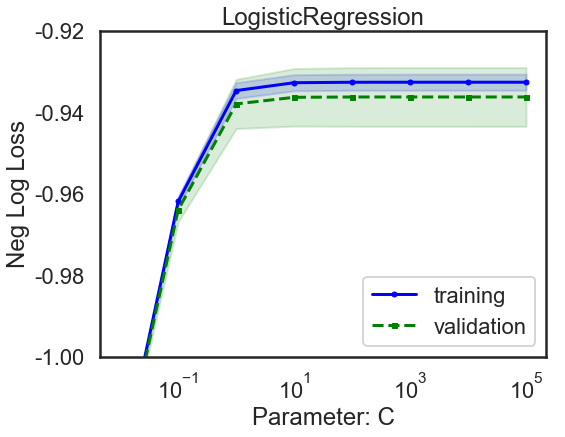

In [25]:
plt.figure(figsize=(8,6))
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),train_mean,
         color='blue',marker='o',
         markersize=5,label='training')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15,color='blue')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='validation')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15,color='green')
plt.xlabel('Parameter: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('Neg Log Loss')
plt.legend(loc='lower right')
plt.title('{}'.format(clf.__class__.__name__))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(-1,-0.92)

# print best cross validation result
print('Best {}:               {}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('Neg. log loss (train): {:.4f}'.format(train_mean[np.argmax(test_mean)]))
print('Neg. log loss (cv):    {:.4f}'.format(np.max(test_mean)))

#### LDA (Linear Discriminant Analysis)

C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warning

train average:            0.9398
cross validation average: 0.9426


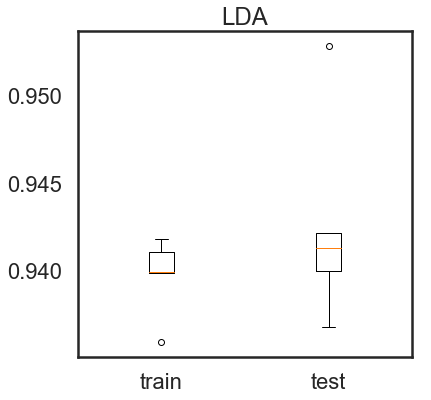

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], ytrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test])))

plt.figure(figsize=(6,6))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('LDA')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### Poisson Regression

2 step modeling:
* Apply poisson regression to predict expected goals for home team and away team from event data;
* Compare expected home team goal to away team goal to predict probability of each match score.

train average:            0.9417
cross validation average: 0.9428


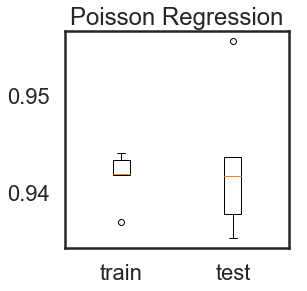

In [21]:
from footballmodels import PoissonRegression
clf = PoissonRegression()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], Xtrain_norm[train], hgoaltrain[train], agoaltrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train], Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test], Xtrain_norm[test])))

plt.figure(figsize=(4,4))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('Poisson Regression')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### Neural Network

In [26]:
import tensorflow as tf
from tensorflow import keras

In [27]:
# Train validation split
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

In [28]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=500,
                    validation_data=(val_x, val_y), verbose=0)

The train acc for last epoch is 56.25%
The train loss for last epoch is 0.936
The val acc for last epoch is 55.90%
The val loss for last epoch is 0.933


(0.9, 1)

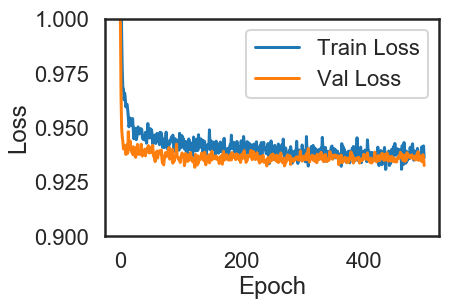

In [29]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('Epoch')
    if kind == 'acc':
        plt.ylabel('Accuracy')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='Train Acc')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = 'Val Acc')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('Loss')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = 'Val Loss')
        plt.legend()


print('The train acc for last epoch is {:.2f}%'.format(history.history['acc'][-1]*100))
print('The train loss for last epoch is {:.3f}'.format(history.history['loss'][-1]))

print('The val acc for last epoch is {:.2f}%'.format(history.history['val_acc'][-1]*100))
print('The val loss for last epoch is {:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.9, 1)

#### <a id='model_evaluation'></a>4. Model Evaluation

#### 4.1 Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (LogisticRegression)
Log Loss:                   0.9240
Prediction Accuracy:        56.6%


#### 4.2 LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
best_clf = LinearDiscriminantAnalysis()

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)
# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)
#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (LinearDiscriminantAnalysis)
Log Loss:                   0.9297
Prediction Accuracy:        56.6%


C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### 4.3 Poisson Regression

In [34]:
# for poisson regression only
from footballmodels import PoissonRegression
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)
#### Model Evaluation
print('Model Evaluation (Poisson Regression)')
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (Poisson Regression)
Log Loss:                   0.9329
Prediction Accuracy:        56.0%


#### Feature Interpretation

For home team goal prediction, home team shot is most positive correlated, and home team cross stats is most negative correlated.

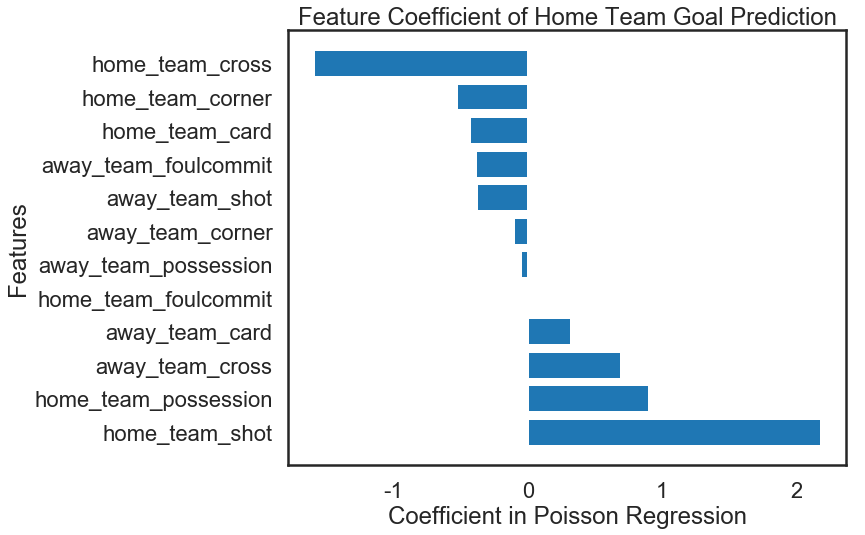

In [35]:
encoded_home_feature_list = feature_list
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('Coefficient in Poisson Regression')
plt.ylabel('Features')
plt.title('Feature Coefficient of Home Team Goal Prediction')
plt.show()

On the other hand, for away team goal prediction, away team shot is most positive correlated, and away team cross is most negative correlated.

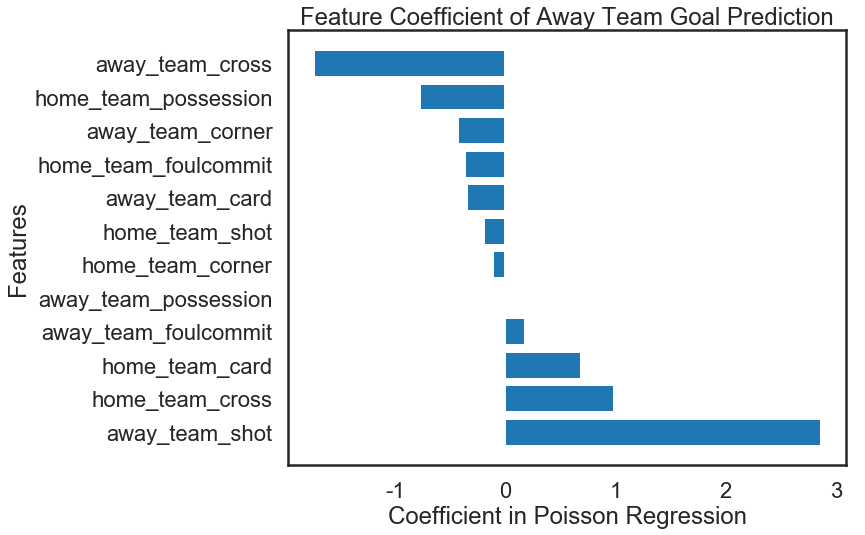

In [36]:
encoded_away_feature_list = feature_list
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('Coefficient in Poisson Regression')
plt.ylabel('Features')
plt.title('Feature Coefficient of Away Team Goal Prediction')
plt.show()

#### 4.4 Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
best_clf = GradientBoostingClassifier(max_depth=3, n_estimators=95)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (GradientBoostingClassifier)
Log Loss:                   0.9327
Prediction Accuracy:        56.4%


#### Feature Interpretation

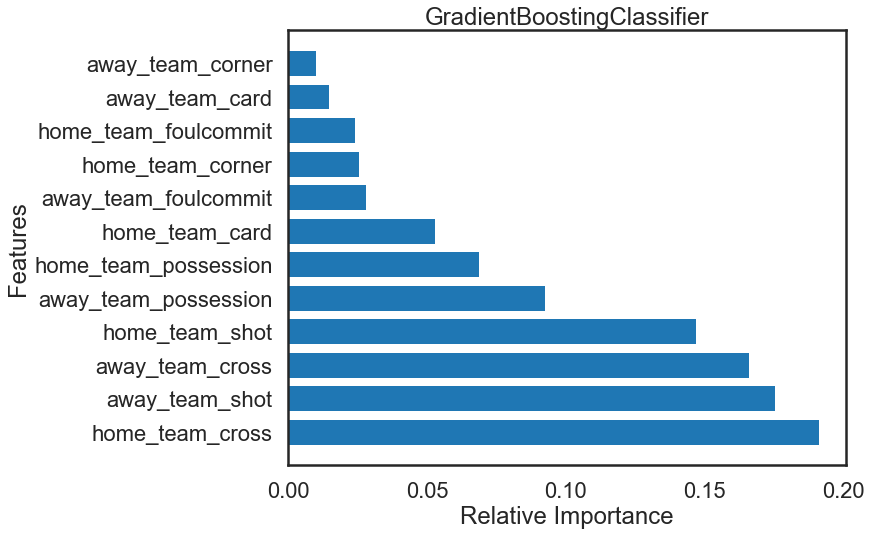

In [39]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('{}'.format(best_clf.__class__.__name__))
plt.show()

#### 4.5 Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
best_clf = RandomForestClassifier(max_features=3, n_estimators=210)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (RandomForestClassifier)
Log Loss:                   0.9481
Prediction Accuracy:        55.80%


#### Feature Interpretation

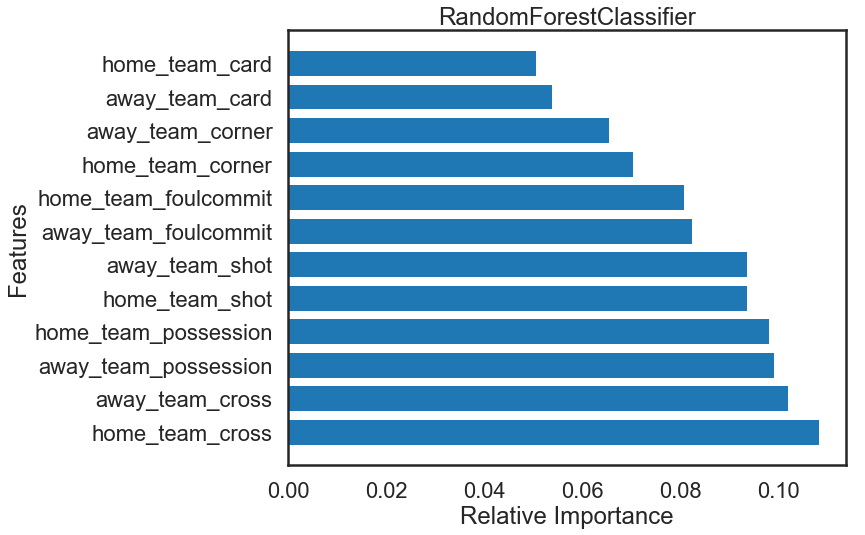

In [41]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('{}'.format(best_clf.__class__.__name__))
plt.show()

#### 4.6 Neural Network

In [43]:
# Fit the data to build model
model.fit(Xtrain_norm, ytrain, epochs=500, verbose=0)

# Output probability estimation
ytest_prob = model.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation (Neural Network)')
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (Neural Network)
Log Loss:                   0.9209
Prediction Accuracy:        56.2%
